## Low light Image Enhancement with Convolutional Neural Network.
Image enhancement is one of the modern topics that are discussed now a days and Deep Learning play a major part in it. We see various types of smartPhones with their night mode in camera which help us to take beautiful images at night or low light situation.

The Camera is not able to take the perfect image at low light because of the noise created at the camera sensors. During night mode the noise is cancelled out by the camera to get the perfect image.

![Low Light Image Enhancement](https://www.soyacincau.com/wp-content/uploads/2014/04/140415-ASUS-PixelMaster.jpg)

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import cv2 as cv
import matplotlib.pyplot as plt
from keras.preprocessing import image
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.inception_resnet_v2 import preprocess_input,decode_predictions
from keras import backend as K
from keras.layers import add, Conv2D,MaxPooling2D,UpSampling2D,Input,BatchNormalization, RepeatVector, Reshape
from keras.layers.merge import concatenate
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from tensorflow import set_random_seed
set_random_seed(2)
np.random.seed(1)
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


['image-classification', 'keras-pretrained-models']


In [2]:
InputPath="../input/image-classification/images/images/art and culture/"

In [3]:
def noisy(noise_typ,image):
    if noise_typ == "gauss":
        row,col,ch= image.shape
        mean = 0
        var = 0.0001
        sigma = var**0.05
        gauss = np.random.normal(mean,sigma,(row,col,ch))
        gauss = gauss.reshape(row,col,ch)
        noisy =  gauss + image
        return noisy
    elif noise_typ == "s&p":
        row,col,ch = image.shape
        s_vs_p = 0.5
        amount = 1.0
        out = np.copy(image)
        # Salt mode
        num_salt = np.ceil(image.size * s_vs_p)
        coords = [np.random.randint(0, i, int(num_salt))
              for i in image.shape]
        out[coords] = 1

        # Pepper mode
        num_pepper = np.ceil(image.size * (1. - s_vs_p))
        coords = [np.random.randint(0, i , int(num_pepper))
              for i in image.shape]
        out[coords] = 1
        return out
    elif noise_typ == "poisson":
        vals = len(np.unique(image))
        vals = 2 ** np.ceil(np.log2(vals))
        noisy = np.random.poisson(image * vals) / float(vals)
        return noisy
    elif noise_typ =="speckle":
        row,col,ch = image.shape
        gauss = np.random.randn(row,col,ch)
        gauss = gauss.reshape(row,col,ch)        
        noisy = image + image * gauss
        return noisy

## REAL IMAGE

255

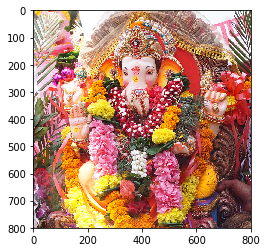

In [5]:
img = cv.imread(InputPath+"0 (4).jpg")  
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
l = img.max()
plt.imshow(img)
l

## IMAGE WITH NOISE(SALT AND PEPPER NOISE)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:20: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:26: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


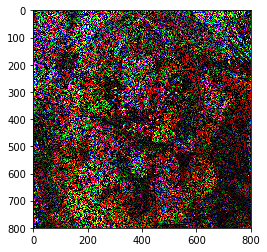

In [6]:
Noise = noisy("s&p",img)
plt.imshow(Noise)

  ## IMAGE WITH LOW-BRIGHTNESS AND SALT-PEPPER NOISE TO GET THE PERFECT LOW-LIGHT IMAGE

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:20: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:26: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


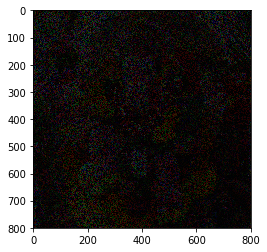

In [7]:
hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV) #convert it to hsv
hsv[...,2] = hsv[...,2]*0.2
img1 = cv.cvtColor(hsv, cv.COLOR_HSV2BGR)
Noise2 = noisy("s&p",img1)

plt.imshow(Noise2)

In [8]:
def PreProcessData(ImagePath):
    X_=[]
    y_=[]
    count=0
    for imageDir in os.listdir(ImagePath):
        if count<2131:
            try:
                count=count+1
                img = cv.imread(ImagePath + imageDir)
                img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
                img_y = cv.resize(img,(500,500))
                hsv = cv.cvtColor(img_y, cv.COLOR_BGR2HSV) #convert it to hsv
                hsv[...,2] = hsv[...,2]*0.2
                img_1 = cv.cvtColor(hsv, cv.COLOR_HSV2BGR)
                Noisey_img = noisy("s&p",img_1)
                X_.append(Noisey_img)
                y_.append(img_y)
            except:
                pass
    X_ = np.array(X_)
    y_ = np.array(y_)
    
    return X_,y_

In [9]:
X_,y_ = PreProcessData(InputPath)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:20: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:26: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


In [10]:
K.clear_session()
def InstantiateModel(in_):
    
    model_1 = Conv2D(16,(3,3), activation='relu',padding='same',strides=1)(in_)
    model_1 = Conv2D(32,(3,3), activation='relu',padding='same',strides=1)(model_1)
    model_1 = Conv2D(64,(2,2), activation='relu',padding='same',strides=1)(model_1)
    
    model_2 = Conv2D(32,(3,3), activation='relu',padding='same',strides=1)(in_)
    model_2 = Conv2D(64,(2,2), activation='relu',padding='same',strides=1)(model_2)
    
    model_2_0 = Conv2D(64,(2,2), activation='relu',padding='same',strides=1)(model_2)
    
    model_add = add([model_1,model_2,model_2_0])
    
    model_3 = Conv2D(64,(3,3), activation='relu',padding='same',strides=1)(model_add)
    model_3 = Conv2D(32,(3,3), activation='relu',padding='same',strides=1)(model_3)
    model_3 = Conv2D(16,(2,2), activation='relu',padding='same',strides=1)(model_3)
    
    model_3_1 = Conv2D(32,(3,3), activation='relu',padding='same',strides=1)(model_add)
    model_3_1 = Conv2D(16,(2,2), activation='relu',padding='same',strides=1)(model_3_1)
    
    model_3_2 = Conv2D(16,(2,2), activation='relu',padding='same',strides=1)(model_add)
    
    model_add_2 = add([model_3_1,model_3_2,model_3])
    
    model_4 = Conv2D(16,(3,3), activation='relu',padding='same',strides=1)(model_add_2)
    model_4_1 = Conv2D(16,(3,3), activation='relu',padding='same',strides=1)(model_add)
    #Extension
    model_add_3 = add([model_4_1,model_add_2,model_4])
    
    model_5 = Conv2D(16,(3,3), activation='relu',padding='same',strides=1)(model_add_3)
    model_5 = Conv2D(16,(2,2), activation='relu',padding='same',strides=1)(model_add_3)
    
    model_5 = Conv2D(3,(3,3), activation='relu',padding='same',strides=1)(model_5)
    
    return model_5
    

In [11]:
Input_Sample = Input(shape=(500, 500,3))
Output_ = InstantiateModel(Input_Sample)
Model_Enhancer = Model(inputs=Input_Sample, outputs=Output_)

In [12]:
Model_Enhancer.compile(optimizer="adam", loss='mean_squared_error')
Model_Enhancer.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 500, 500, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 500, 500, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 500, 500, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 500, 500, 32) 4640        conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_5 (

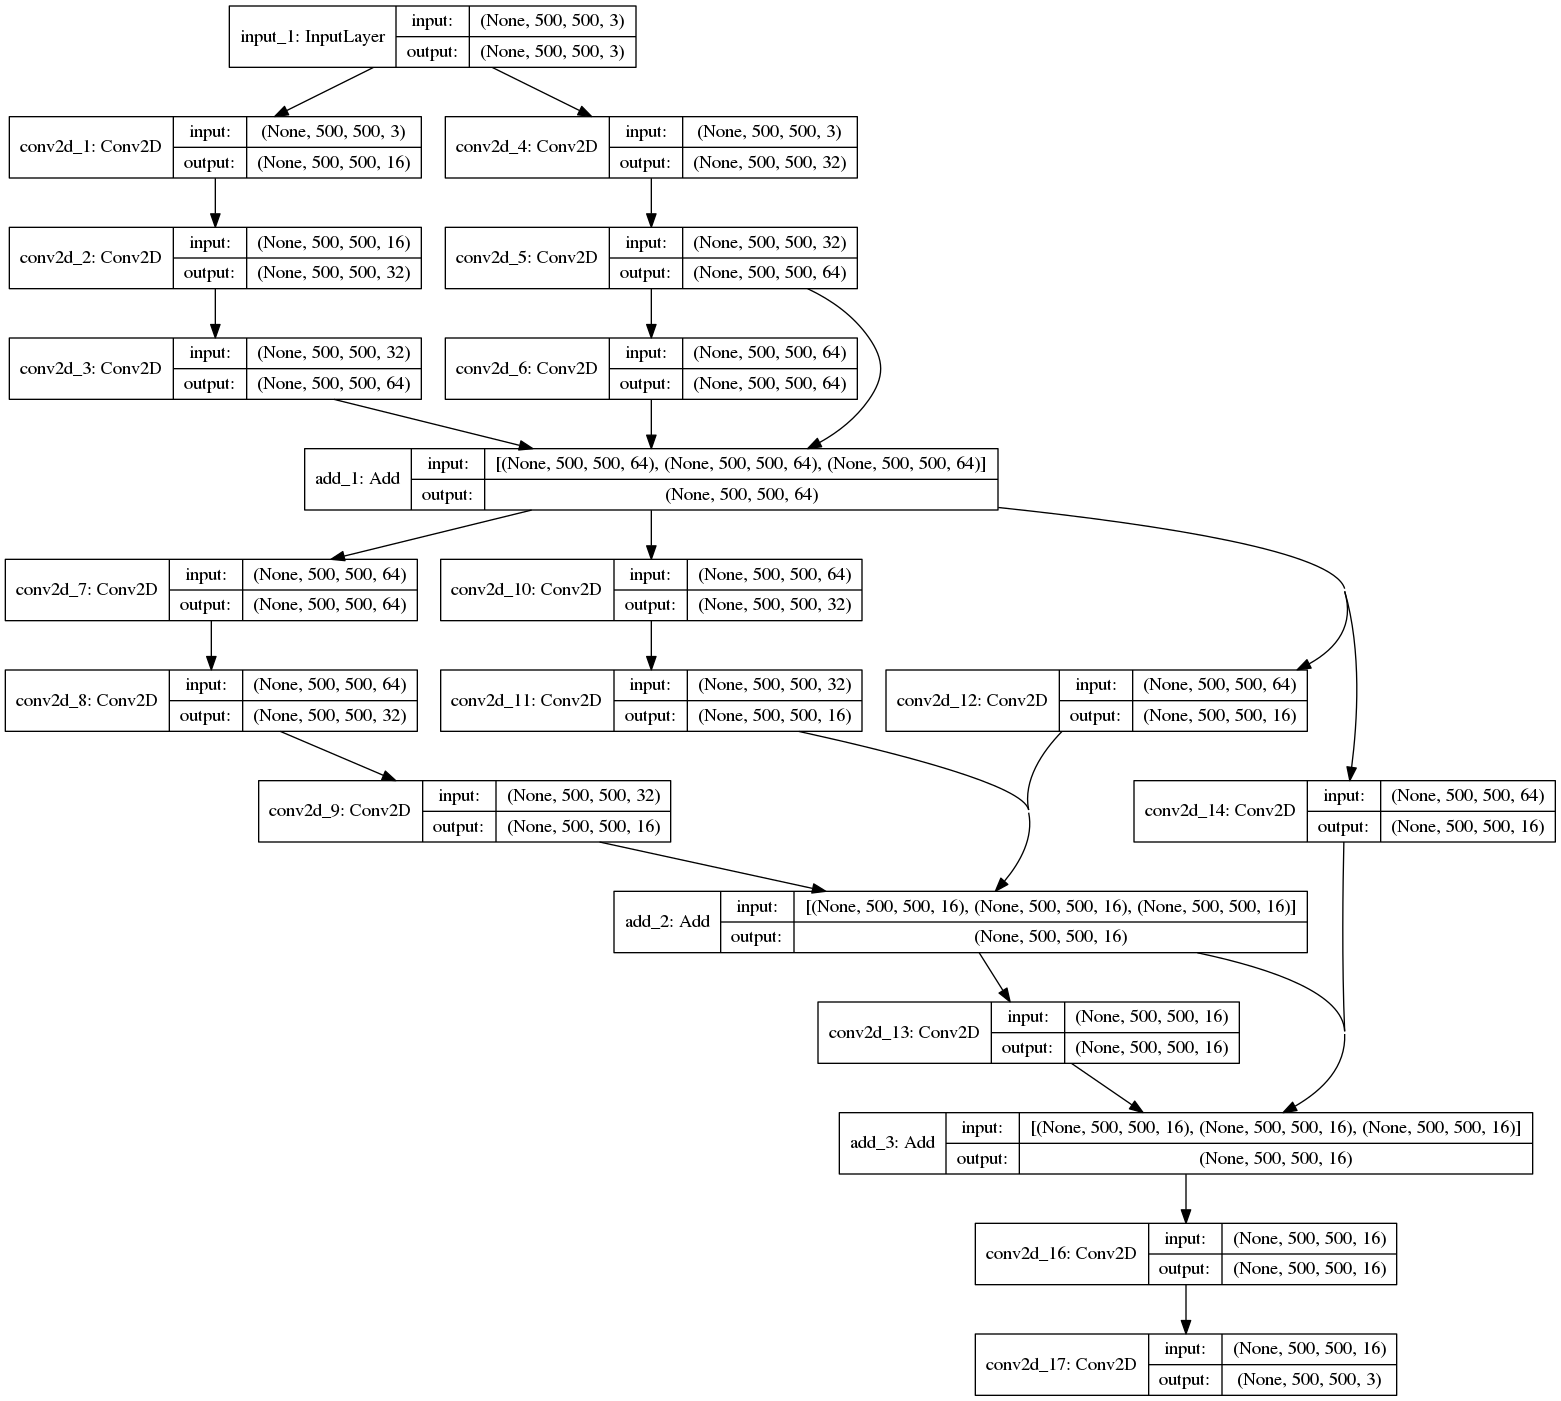

In [13]:
from keras.utils.vis_utils import plot_model
plot_model(Model_Enhancer,to_file='model_.png',show_shapes=True, show_layer_names=True)
from IPython.display import Image
Image(retina=True, filename='model_.png')

In [14]:
def GenerateInputs(X,y):
    for i in range(len(X)):
        X_input = X[i].reshape(1,500,500,3)
        y_input = y[i].reshape(1,500,500,3)
        yield (X_input,y_input)
Model_Enhancer.fit_generator(GenerateInputs(X_,y_),epochs=53,verbose=1,steps_per_epoch=39,shuffle=True)

Epoch 1/53
39/39 [==============================] - 9s 227ms/step - loss: 7290.1480
Epoch 2/53
39/39 [==============================] - 3s 66ms/step - loss: 1461.7810
Epoch 3/53
39/39 [==============================] - 3s 65ms/step - loss: 1545.2948
Epoch 4/53
39/39 [==============================] - 3s 64ms/step - loss: 1112.9950
Epoch 5/53
39/39 [==============================] - 3s 65ms/step - loss: 970.0546
Epoch 6/53
39/39 [==============================] - 3s 65ms/step - loss: 1116.4731
Epoch 7/53
39/39 [==============================] - 3s 66ms/step - loss: 766.8258
Epoch 8/53
39/39 [==============================] - 3s 65ms/step - loss: 630.6135
Epoch 9/53
39/39 [==============================] - 3s 66ms/step - loss: 820.5512
Epoch 10/53
39/39 [==============================] - 3s 64ms/step - loss: 894.7733
Epoch 11/53
39/39 [==============================] - 3s 66ms/step - loss: 649.1390
Epoch 12/53
39/39 [==============================] - 3s 65ms/step - loss: 662.2240
Epoch 1

In [15]:
TestPath="../input/image-classification/images/images/art and culture/"

In [16]:
def ExtractTestInput(ImagePath):
    img = cv.imread(ImagePath)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    img_ = cv.resize(img,(500,500))
    hsv = cv.cvtColor(img_, cv.COLOR_BGR2HSV) #convert it to hsv
    hsv[...,2] = hsv[...,2]*0.2
    img1 = cv.cvtColor(hsv, cv.COLOR_HSV2BGR)
    Noise = noisy("s&p",img1)
    Noise = Noise.reshape(1,500,500,3)
    return Noise

In [26]:
ImagePath=TestPath+"101 (6).jpg"
image_for_test = ExtractTestInput(ImagePath)
Prediction = Model_Enhancer.predict(image_for_test)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:20: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:26: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


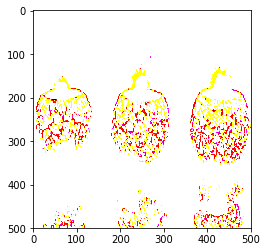

In [27]:
Prediction = Prediction.reshape(500,500,3)
plt.imshow(Prediction)

## COMPARATIVE ANALYSIS OF THE ENHANCED IMAGE WITH RESPECT TO GROUND TRUTH IMAGE

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:20: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:26: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


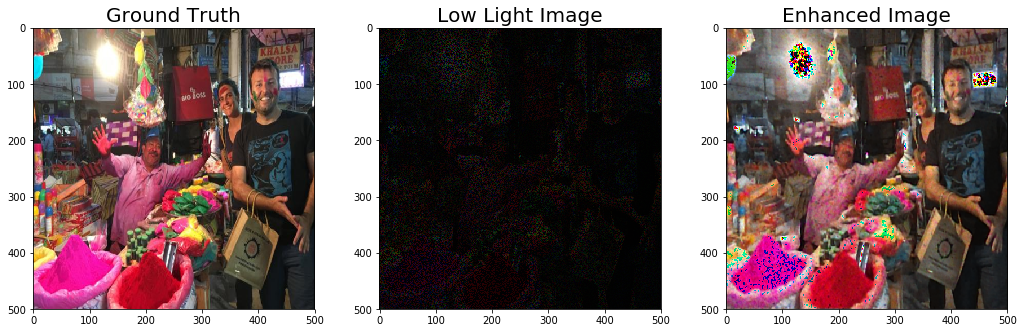

In [25]:
Image_test=TestPath+"101 (6).jpg"
plt.figure(figsize=(30,30))
plt.subplot(5,5,1)
img_1 = cv.imread(Image_test)
img_1 = cv.cvtColor(img_1, cv.COLOR_BGR2RGB)
img_1 = cv.resize(img_1, (500, 500))
plt.title("Ground Truth",fontsize=20)
plt.imshow(img_1)

plt.subplot(5,5,1+1)
img_ = ExtractTestInput(Image_test)
img_ = img_.reshape(500,500,3)
plt.title("Low Light Image",fontsize=20)
plt.imshow(img_)

plt.subplot(5,5,1+2)
img_[:,:,:] = Prediction[:,:,:]
plt.title("Enhanced Image",fontsize=20)
plt.imshow(img_)


In [ ]:
TestPath2="../input/image-classification/validation/validation/travel and adventure/"

In [ ]:
Image_test2=TestPath2+"0.jpg"
plt.figure(figsize=(30,30))
plt.subplot(5,5,1)
img_1 = cv.imread(Image_test2)
img_1 = cv.cvtColor(img_1, cv.COLOR_BGR2RGB)
img_1 = cv.resize(img_1, (500, 500))
plt.title("Ground Truth",fontsize=20)
plt.imshow(img_1)

plt.subplot(5,5,1+1)
img_ = ExtractTestInput(Image_test2)
Prediction = Model_Enhancer.predict(img_)
img_ = img_.reshape(500,500,3)
plt.title("Low Light Image",fontsize=20)
plt.imshow(img_)

plt.subplot(5,5,1+2)
Prediction = Prediction.reshape(500,500,3)
img_[:,:,:] = Prediction[:,:,:]
plt.title("Enhanced Image",fontsize=20)
plt.imshow(img_)


In [ ]:
Image_test2=TestPath2+"13.jpg"
plt.figure(figsize=(30,30))
plt.subplot(5,5,1)
img_1 = cv.imread(Image_test2)
img_1 = cv.cvtColor(img_1, cv.COLOR_BGR2RGB)
img_1 = cv.resize(img_1, (500, 500))
plt.title("Ground Truth",fontsize=20)
plt.imshow(img_1)

plt.subplot(5,5,1+1)
img_ = ExtractTestInput(Image_test2)
Prediction = Model_Enhancer.predict(img_)
img_ = img_.reshape(500,500,3)
plt.title("Low Light Image",fontsize=20)
plt.imshow(img_)

plt.subplot(5,5,1+2)
Prediction = Prediction.reshape(500,500,3)
img_[:,:,:] = Prediction[:,:,:]
plt.title("Enhanced Image",fontsize=20)
plt.imshow(img_)


In [ ]:
Image_test2=TestPath2+"18.jpg"
plt.figure(figsize=(30,30))
plt.subplot(5,5,1)
img_1 = cv.imread(Image_test2)
img_1 = cv.cvtColor(img_1, cv.COLOR_BGR2RGB)
img_1 = cv.resize(img_1, (500, 500))
plt.title("Ground Truth",fontsize=20)
plt.imshow(img_1)

plt.subplot(5,5,1+1)
img_ = ExtractTestInput(Image_test2)
Prediction = Model_Enhancer.predict(img_)
img_ = img_.reshape(500,500,3)
plt.title("Low Light Image",fontsize=20)
plt.imshow(img_)

plt.subplot(5,5,1+2)
Prediction = Prediction.reshape(500,500,3)
img_[:,:,:] = Prediction[:,:,:]
plt.title("Enhanced Image",fontsize=20)
plt.imshow(img_)


In [ ]:
Image_test2=TestPath2+"2.jpg"
plt.figure(figsize=(30,30))
plt.subplot(5,5,1)
img_1 = cv.imread(Image_test2)
img_1 = cv.cvtColor(img_1, cv.COLOR_BGR2RGB)
img_1 = cv.resize(img_1, (500, 500))
plt.title("Ground Truth",fontsize=20)
plt.imshow(img_1)

plt.subplot(5,5,1+1)
img_ = ExtractTestInput(Image_test2)
Prediction = Model_Enhancer.predict(img_)
img_ = img_.reshape(500,500,3)
plt.title("Low Light Image",fontsize=20)
plt.imshow(img_)

plt.subplot(5,5,1+2)
Prediction = Prediction.reshape(500,500,3)
img_[:,:,:] = Prediction[:,:,:]
plt.title("Enhanced Image",fontsize=20)
plt.imshow(img_)


In [ ]:
Image_test2=TestPath2+"14.jpg"
plt.figure(figsize=(30,30))
plt.subplot(5,5,1)
img_1 = cv.imread(Image_test2)
img_1 = cv.cvtColor(img_1, cv.COLOR_BGR2RGB)
img_1 = cv.resize(img_1, (500, 500))
plt.title("Ground Truth",fontsize=20)
plt.imshow(img_1)

plt.subplot(5,5,1+1)
img_ = ExtractTestInput(Image_test2)
Prediction = Model_Enhancer.predict(img_)
img_ = img_.reshape(500,500,3)
plt.title("Low Light Image",fontsize=20)
plt.imshow(img_)

plt.subplot(5,5,1+2)
Prediction = Prediction.reshape(500,500,3)
img_[:,:,:] = Prediction[:,:,:]
plt.title("Enhanced Image",fontsize=20)
plt.imshow(img_)


In [ ]:
Image_test2=TestPath2+"11.jpg"
plt.figure(figsize=(30,30))
plt.subplot(5,5,1)
img_1 = cv.imread(Image_test2)
img_1 = cv.cvtColor(img_1, cv.COLOR_BGR2RGB)
img_1 = cv.resize(img_1, (500, 500))
plt.title("Ground Truth",fontsize=20)
plt.imshow(img_1)

plt.subplot(5,5,1+1)
img_ = ExtractTestInput(Image_test2)
Prediction = Model_Enhancer.predict(img_)
img_ = img_.reshape(500,500,3)
plt.title("Low Light Image",fontsize=20)
plt.imshow(img_)

plt.subplot(5,5,1+2)
Prediction = Prediction.reshape(500,500,3)
img_[:,:,:] = Prediction[:,:,:]
plt.title("Enhanced Image",fontsize=20)
plt.imshow(img_)


In [ ]:
Image_test2=TestPath2+"10.jpg"
plt.figure(figsize=(30,30))
plt.subplot(5,5,1)
img_1 = cv.imread(Image_test2)
img_1 = cv.cvtColor(img_1, cv.COLOR_BGR2RGB)
img_1 = cv.resize(img_1, (500, 500))
plt.title("Ground Truth",fontsize=20)
plt.imshow(img_1)

plt.subplot(5,5,1+1)
img_ = ExtractTestInput(Image_test2)
Prediction = Model_Enhancer.predict(img_)
img_ = img_.reshape(500,500,3)
plt.title("Low Light Image",fontsize=20)
plt.imshow(img_)

plt.subplot(5,5,1+2)
Prediction = Prediction.reshape(500,500,3)
img_[:,:,:] = Prediction[:,:,:]
plt.title("Enhanced Image",fontsize=20)
plt.imshow(img_)


In [ ]:
Image_test2=TestPath2+"12.jpg"
plt.figure(figsize=(30,30))
plt.subplot(5,5,1)
img_1 = cv.imread(Image_test2)
img_1 = cv.cvtColor(img_1, cv.COLOR_BGR2RGB)
img_1 = cv.resize(img_1, (500, 500))
plt.title("Ground Truth",fontsize=20)
plt.imshow(img_1)

plt.subplot(5,5,1+1)
img_ = ExtractTestInput(Image_test2)
Prediction = Model_Enhancer.predict(img_)
img_ = img_.reshape(500,500,3)
plt.title("Low Light Image",fontsize=20)
plt.imshow(img_)

plt.subplot(5,5,1+2)
Prediction = Prediction.reshape(500,500,3)
img_[:,:,:] = Prediction[:,:,:]
plt.title("Enhanced Image",fontsize=20)
plt.imshow(img_)


## conclusion

1. The model works preety good with low light images.
2. We have used salt and peeper noise to train the model with a relistic low light image although it is not tested for other type of noises.
3. The model is producing inappropriate results in case of enhancing a very bright section of an image. The reason might be due to presence of salt pepper noise and might produce better results in case of real-time low light image.
